In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

face_cascade = cv2.CascadeClassifier('/home/mckc/Downloads/opencv-2.4.13/data/haarcascades_GPU/haarcascade_frontalface_default.xml')

In [2]:
#Reading the image data into numpy
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:], [0.299, 0.587, 0.114])

def load_data():
    import pandas as pd
    import numpy as np
    from PIL import Image
    
    train = pd.read_csv('/home/mckc/All Data/train.csv')
    test = pd.read_csv('/home/mckc/All Data/test.csv')
    print 'the training data shape is ',train.shape
    print 'the test data shape is ', test.shape
    
    X_tr = np.zeros((1,1944,2592),dtype=np.uint8)
    iteration = 0
    for i in train.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
#     print X_tr.shape,image.shape
        X_tr =  np.vstack((X_tr,image))
        iteration+=1
        if iteration % 50==0:
            print colored((float(iteration)/len(train.values[:,0])*100 ,' Percentage complete'), 'green')
    Y_tr = train.values[:,1]
    X_tr = X_tr[1:,:,:]
    X_ts = np.zeros((1,1944,2592),dtype=np.uint8)
    for i in test.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
        X_ts = np.vstack((X_ts,image))
    Y_ts = test.values[:,1]
    X_ts = X_ts[1:,:,:]
    print 'the training file shape',X_tr.shape,Y_tr.shape
    print 'the testing file shape',X_ts.shape,Y_ts.shape
    
    return X_tr,X_ts,Y_tr,Y_ts    

In [3]:
def simulate(X,Y):
    import scipy as sp
    import scipy.ndimage
    complete = np.zeros((1,96,96),dtype=np.uint8)
    Y_complete = []
    for i in range(len(X)):
        complete = np.vstack((complete,X[i,:,:].reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -10,reshape=False,cval=1).reshape(1,96,96)))
        rotated = np.fliplr(X[i,:,:])
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,rotated.reshape(1,96,96)))
        Y_complete = np.append(Y_complete,([Y[i]]*14))
        if i % 50==0:
            print colored((float(i)/len(X)*100 ,' Percentage complete'),'green')
    complete = complete[1:,:,:]
    return complete,Y_complete

In [4]:
def extract_faces(X_tr,Y_tr):
    from skimage.transform import resize
    import time
    start_time = time.clock()
    all_faces = np.zeros((1,96,96),dtype=np.uint8)
    missing = []
    multiple = []
    Y= []
    for i in range(len(X_tr)):
        faces  = face_cascade.detectMultiScale(X_tr[i,:,:],scaleFactor=1.3,minNeighbors=5,minSize=(70, 70))
        n_faces = len(faces)
        if n_faces is 1:
            for (x,y,w,h) in faces:
                fac = np.array(X_tr[i,:,:])[y:(y+h),x:(x+h)]
                out = (resize(fac,(96,96))).reshape((1,96,96))
                all_faces = np.vstack((all_faces,out))
                Y = np.append(Y,Y_tr[i])
        else:
            if n_faces > 1:
                #print ('There are multiple faces for index %d and with length %d' % (i , n_faces))
                missing = np.append(missing,i)
                #all_faces = np.vstack((all_faces,np.zeros((1,96,96),dtype=np.uint8)))
            else:
                #print ('The face is missing for index %d' %i)
                multiple = np.append(multiple,i)
        if i % 50==0:
            print colored((float(i)/len(X_tr)*100 ,' Percentage complete'), 'green')

    all_faces = all_faces[1:,:,:]
    print all_faces.shape
    print time.clock() - start_time, "seconds"
    return all_faces,missing,multiple,Y

In [5]:
def load(data):
    import os
    import numpy as np
    files = os.listdir('/home/mckc/all_'+data+'/')    
    X = np.zeros((1,96,96),dtype=np.float64)
    Y = []
    iter = 0
    for i in files:
        X = np.vstack((X,np.load('/home/mckc/all_'+data+'/'+i).reshape(1,96,96)))
        index = i.index('_')
        Y = np.append(Y,i[:index])
        iter = iter+1
        if iter % 800 ==0:
            print colored((float(iter)/len(files)*100 ,' Percentage complete'), 'green')
            
    print X[1:,:,:].shape,Y.shape
    return X[1:,:,:],Y

In [6]:
def Save_data(X,Y,data):
    for i in range(len(X)):
        file_name = '/home/mckc/all_'+data+'/'+Y[i]+'_'+str(i)+'.npy'
        np.save(file_name,X[i,:,:])

In [7]:
X_tr,X_tst,Y_tr,Y_tst = load_data()

the training data shape is  (586, 2)
the test data shape is  (195, 2)
(8.532423208191126, ' Percentage complete')
(17.064846416382252, ' Percentage complete')
(25.597269624573375, ' Percentage complete')
(34.129692832764505, ' Percentage complete')
(42.66211604095563, ' Percentage complete')
(51.19453924914675, ' Percentage complete')
(59.72696245733788, ' Percentage complete')
(68.25938566552901, ' Percentage complete')
(76.79180887372013, ' Percentage complete')
(85.32423208191126, ' Percentage complete')
(93.85665529010238, ' Percentage complete')
the training file shape (586, 1944, 2592) (586,)
the testing file shape (195, 1944, 2592) (195,)


In [8]:
X_train,missing,multiple,Y_train = extract_faces(X_tr[:,:,:],Y_tr)
X_test,missing_test,multiple_test,Y_test = extract_faces(X_tst,Y_tst)

(0.0, ' Percentage complete')
(8.532423208191126, ' Percentage complete')
(17.064846416382252, ' Percentage complete')
(25.597269624573375, ' Percentage complete')
(34.129692832764505, ' Percentage complete')
(42.66211604095563, ' Percentage complete')
(51.19453924914675, ' Percentage complete')
(59.72696245733788, ' Percentage complete')
(68.25938566552901, ' Percentage complete')
(76.79180887372013, ' Percentage complete')
(85.32423208191126, ' Percentage complete')
(93.85665529010238, ' Percentage complete')
(498, 96, 96)
375.303223 seconds
(0.0, ' Percentage complete')
(25.64102564102564, ' Percentage complete')
(51.28205128205128, ' Percentage complete')
(76.92307692307693, ' Percentage complete')
(165, 96, 96)
123.808383 seconds


In [9]:
import time
start_time = time.clock()
X,Y = simulate(X_train,Y_train)
print X.shape,Y.shape
print time.clock() - start_time, "seconds"

(0.0, ' Percentage complete')
(10.040160642570282, ' Percentage complete')
(20.080321285140563, ' Percentage complete')
(30.120481927710845, ' Percentage complete')
(40.16064257028113, ' Percentage complete')
(50.20080321285141, ' Percentage complete')
(60.24096385542169, ' Percentage complete')
(70.28112449799197, ' Percentage complete')
(80.32128514056225, ' Percentage complete')
(90.36144578313254, ' Percentage complete')
(6972, 96, 96) (6972,)
247.029177 seconds


In [10]:
Save_data(X,Y,'train')
Save_data(X_test,Y_test,'test')

In [12]:
X.shape,Y.shape

((6972, 96, 96), (6972,))

In [3]:
X,Y = load('train')
X_test,Y_test = load('test')

(4.726456339359565, ' Percentage complete')
(9.45291267871913, ' Percentage complete')
(14.179369018078697, ' Percentage complete')
(18.90582535743826, ' Percentage complete')
(23.632281696797826, ' Percentage complete')
(28.358738036157394, ' Percentage complete')
(33.085194375516956, ' Percentage complete')
(37.81165071487652, ' Percentage complete')
(42.538107054236086, ' Percentage complete')
(47.26456339359565, ' Percentage complete')
(51.99101973295521, ' Percentage complete')
(56.71747607231479, ' Percentage complete')
(61.44393241167435, ' Percentage complete')
(66.17038875103391, ' Percentage complete')
(70.89684509039348, ' Percentage complete')
(75.62330142975304, ' Percentage complete')
(80.3497577691126, ' Percentage complete')
(85.07621410847217, ' Percentage complete')
(89.80267044783173, ' Percentage complete')
(94.5291267871913, ' Percentage complete')
(99.25558312655087, ' Percentage complete')
(16926, 96, 96) (16926,)
(394, 96, 96) (394,)


In [11]:
def standard(X):
    return (X - X.mean())/X.max()

X_test = standard(X_test)
X = standard(X)

In [12]:
X_normal = X.reshape(-1,9216)
X_test_normal = X_test.reshape(-1,9216)
map, Y_number = np.unique(Y, return_inverse=True)
Y_test_number = np.unique(Y_test, return_inverse=True)[1]

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = LogisticRegression(verbose=0,n_jobs=-1,multi_class='multinomial',solver='lbfgs',max_iter=100,warm_start=True)
#scores = cross_validation.cross_val_score(clf, X_normal, Y_number, cv=5)
#print scores
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [14]:
clf.fit(X_normal,Y_number)
Y_logictic= clf.predict(X_test.reshape(-1,9216))
Y_log_vales = map[Y_logictic]

print 'Accuracy of the model is ',accuracy_score(Y_test,Y_log_vales)
confusion_matrix(Y_log_vales,Y_test)

Accuracy of the model is  0.987878787879


array([[18,  0,  0,  0,  0,  0,  0],
       [ 0, 19,  0,  0,  0,  0,  1],
       [ 0,  0, 25,  0,  0,  0,  0],
       [ 0,  0,  0, 23,  0,  0,  0],
       [ 0,  0,  0,  0, 26,  0,  0],
       [ 0,  0,  0,  0,  0, 17,  0],
       [ 0,  0,  0,  0,  0,  1, 35]])

In [15]:
clf.coef_.shape

(7, 9216)

Abhay


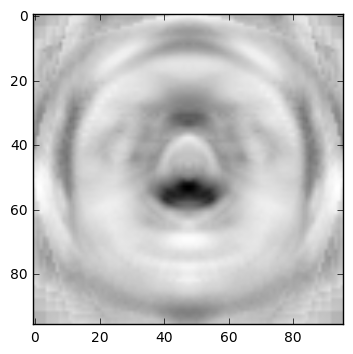

In [16]:
print map[0]
plt.imshow(clf.coef_[0,:].reshape(96,96),cmap=cm.Greys_r)

Arun


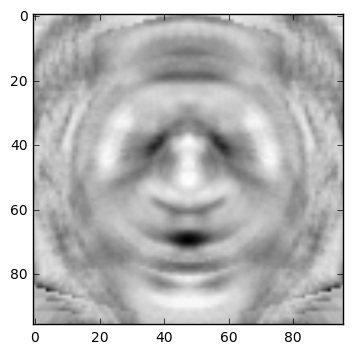

In [17]:
print map[1]
plt.imshow(clf.coef_[1,:].reshape(96,96),cmap=cm.Greys_r)

Gopika


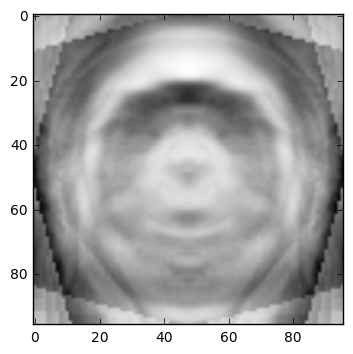

In [18]:
print map[2]
plt.imshow(clf.coef_[2,:].reshape(96,96),cmap=cm.Greys_r)

Kinkar


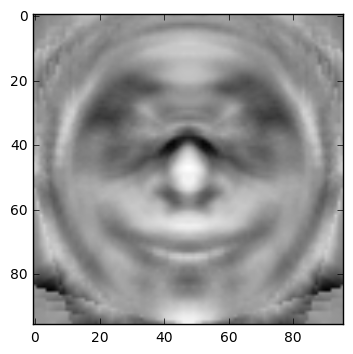

In [19]:
print map[3]
plt.imshow(clf.coef_[3,:].reshape(96,96),cmap=cm.Greys_r)

Omar


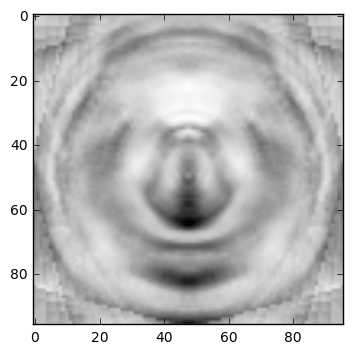

In [20]:
print map[4]
plt.imshow(clf.coef_[4,:].reshape(96,96),cmap=cm.Greys_r)

Pandian


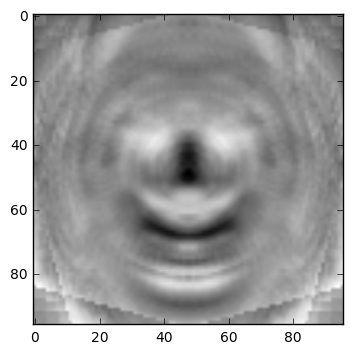

In [21]:
print map[5]
plt.imshow(clf.coef_[5,:].reshape(96,96),cmap=cm.Greys_r)

Sharath


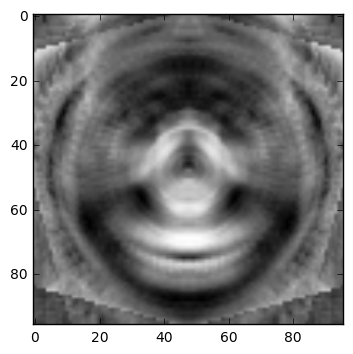

In [22]:
print map[6]
plt.imshow(clf.coef_[6,:].reshape(96,96),cmap=cm.Greys_r)

In [23]:
from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(200,verbose=0,oob_score=True,n_jobs=-1,warm_start=True)
#scores = cross_validation.cross_val_score(recognizer, X_normal, Y_number, cv=5)
#print scores
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [24]:
recognizer.fit(X_normal,Y_number)

Y_rf= recognizer.predict(X_test.reshape(-1,9216))
Y_rf_vales = map[Y_rf]

print 'Accuracy of the model is ',accuracy_score(Y_test,Y_rf_vales)
confusion_matrix(Y_test,Y_rf_vales)

Accuracy of the model is  0.981818181818


array([[18,  0,  0,  0,  0,  0,  0],
       [ 1, 18,  0,  0,  0,  0,  0],
       [ 0,  0, 25,  0,  0,  0,  0],
       [ 0,  0,  0, 23,  0,  0,  0],
       [ 1,  0,  0,  0, 25,  0,  0],
       [ 0,  0,  0,  0,  0, 17,  1],
       [ 0,  0,  0,  0,  0,  0, 36]])

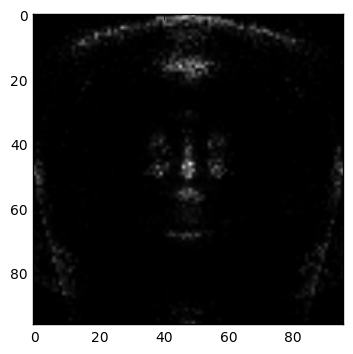

In [25]:
importances = recognizer.feature_importances_
importance_image = importances.reshape(96,96)
#plt.figure(figsize=(7,7))
plt.imshow(importance_image,cmap=cm.Greys_r)

In [26]:
import lasagne
#from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
#from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
from lasagne import layers
from lasagne.objectives import categorical_crossentropy
from lasagne.updates import nesterov_momentum,adadelta
from nolearn.lasagne import BatchIterator,visualize,NeuralNet
Conv2DLayer = layers.Conv2DLayer
MaxPool2DLayer = layers.MaxPool2DLayer

net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=7,
    
    update = adadelta,
    update_learning_rate=0.1,
#    update_momentum=0.9,
    max_epochs=15,
    verbose=1
)

Using gpu device 0: Quadro M2000M (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)


In [31]:
net.fit(X.reshape(-1,1,96,96).astype(np.float32), Y_number.astype(np.uint8))

/home/mckc/anaconda/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 16538479 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    7

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     1.32024     0.51791    2.54915      0.81464  19.05s
      2     0.28197     0.06170    4.57024      0.98524  19.19s
      3     0.06383     0.01534    4.16053      0.99675  19.17s
      4     0.03254     0.00575    5.65802      0.99823  19.13s
      5     0.02535     0.00304    8.34033      1.00000  19.07s
      6     0.01907     0.00441    4.31995      0.99911  19.08s
      7     0.01186     0.00238    4.98607      1.0

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f2a745e6ed0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f2a745e6d90>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=1000,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,AveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam,SGD,Adadelta,Adagrad
from keras import backend as K

Y_Keras = np_utils.to_categorical(Y_number, 7)
Y_Keras_test = np_utils.to_categorical(Y_test_number,7)

model = Sequential()
model.add(Convolution2D(32, 3, 3,border_mode='same',input_shape=( 1, 96, 96),activation='relu'))
model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(96, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(192, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(256, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(160, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(320, 3, 3,border_mode='same',activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(1,1)))

model.add(Flatten())
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu'))
model.add(Dense(7,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

model.fit(X.reshape(-1,1,96,96), Y_Keras, nb_epoch=20, batch_size=1,verbose=1,
          validation_data=(X_test.reshape(-1,1,96,96),Y_Keras_test))

Train on 6972 samples, validate on 165 samples
Epoch 1/20
1287/6972 [====>.........................] - ETA: 163s - loss: 1.9330 - acc: 0.1810

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.optimizers import Adam,SGD,Adadelta,Adagrad
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


Y_Keras = np_utils.to_categorical(Y_number, 7)
Y_Keras_test = np_utils.to_categorical(Y_test_number,7)
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
model = Sequential()
model.add(Dense(1000, input_dim=9216,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu'))
model.add(Dense(7,activation='softmax'))
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adagrad = Adagrad(lr=0.01, epsilon=1e-08)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])

model.fit(X.reshape(-1,9216), Y_Keras, nb_epoch=20, batch_size=2,verbose=1,
          validation_data=(X_test.reshape(-1,9216),Y_Keras_test))

Using Theano backend.


Train on 16926 samples, validate on 394 samples
Epoch 1/20
16926/16926 [==============================] - 93s - loss: 12.7053 - acc: 0.2116 - val_loss: 12.7636 - val_acc: 0.2081
Epoch 2/20
16926/16926 [==============================] - 93s - loss: 12.7052 - acc: 0.2117 - val_loss: 12.7636 - val_acc: 0.2081
Epoch 3/20
16926/16926 [==============================] - 93s - loss: 12.7052 - acc: 0.2117 - val_loss: 12.7636 - val_acc: 0.2081
Epoch 4/20
16926/16926 [==============================] - 93s - loss: 12.7052 - acc: 0.2117 - val_loss: 12.7636 - val_acc: 0.2081
Epoch 5/20
16926/16926 [==============================] - 93s - loss: 12.7052 - acc: 0.2117 - val_loss: 12.7636 - val_acc: 0.2081
Epoch 6/20
 2974/16926 [====>.........................] - ETA: 76s - loss: 12.7200 - acc: 0.2108

KeyboardInterrupt: 

In [22]:
import cPickle
# save the classifier
with open('/home/mckc/nolearn_model.pkl', 'wb') as fid:
    cPickle.dump(net, fid)    

np.save('/home/mckc/map',map)

In [20]:
with open('/home/mckc/random_model.pkl', 'wb') as fid:
    cPickle.dump(recognizer, fid)  

NameError: name 'cPickle' is not defined

In [ ]:
with open('/home/mckc/linear_model.pkl', 'wb') as fid:
    cPickle.dump(clf, fid)  

In [ ]:
with open('/home/mckc/model.pkl', 'wb') as fid:
    cPickle.dump(model, fid)  

In [ ]:
with open('/home/mckc/model.pkl', 'rb') as fid:
    Net = cPickle.load(fid)

In [ ]:
with open('/home/mckc/model.pkl', 'rb') as fid:
    Net = cPickle.load(fid)

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("/home/mckc/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/home/mckc/model.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
from keras.models import model_from_json
# load json and create model
json_file = open('/home/mckc//model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/home/mckc//model.h5")
print("Loaded model from disk")

AssertionError: Keyword argument not understood: context_dim